## NLP CW - Michelle Lo, Hetty Symes, Evelyn Nutton

RoBERTa base model

In [23]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import transformers
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline, RobertaModel, AutoTokenizer, AutoModelForSequenceClassification, AdamW, DataCollatorWithPadding, get_scheduler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
import nlpaug.augmenter.word as naw
import sacremoses

In [24]:
# Download content needed for text augmentation
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /homes/hys21/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /homes/hys21/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:

train_df = pd.read_csv("train_dev_data/train_set.csv")
test_df = pd.read_csv("train_dev_data/dev_set.csv")
train_df.head()

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0


In [6]:
# Load the pre-trained model
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, truncation=True, do_lower_case=True)
pretrained_model = RobertaModel.from_pretrained(checkpoint, num_labels=2)
pretrained_model = pretrained_model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
# Class for the data
class PCLData(Dataset):
    def __init__(self, data, tokenizer, max_len, augment=False):
        self.tokenizer = tokenizer
        self.data = data
        self.text = self.data.text
        self.targets = self.data.label
        self.max_len = max_len
        self.augment = augment
        self.synonym_aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        if self.augment:
            text = str(self.synonym_aug.augment(text)[0])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [67]:
MAX_LEN = 256
LEARNING_RATE = 1e-05

In [81]:
print("TRAIN Dataset: {}".format(train_df.shape))
print("TEST Dataset: {}".format(test_df.shape))
train_dataset = PCLData(train_df, tokenizer, MAX_LEN, augment=True)
test_dataset = PCLData(test_df, tokenizer, MAX_LEN, augment=False)

train_params = {'batch_size': 16,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': 4,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(train_dataset, **train_params)
testing_loader = DataLoader(test_dataset, **test_params)

TRAIN Dataset: (8375, 7)
TEST Dataset: (2094, 7)


In [10]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = pretrained_model
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [11]:
model = RobertaClass()
model.to(device)

RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [12]:
# Loss


class SelfAdjDiceLoss(torch.nn.Module):
    r"""
    Creates a criterion that optimizes a multi-class Self-adjusting Dice Loss
    ("Dice Loss for Data-imbalanced NLP Tasks" paper)

    Args:
        alpha (float): a factor to push down the weight of easy examples
        gamma (float): a factor added to both the nominator and the denominator for smoothing purposes
        reduction (string): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed.

    Shape:
        - logits: `(N, C)` where `N` is the batch size and `C` is the number of classes.
        - targets: `(N)` where each value is in [0, C - 1]
    """

    def __init__(self, alpha: float = 1.0, gamma: float = 1.0, reduction: str = "mean") -> None:
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        probs = torch.softmax(logits, dim=1)
        probs = torch.gather(probs, dim=1, index=targets.unsqueeze(1))

        probs_with_factor = ((1 - probs) ** self.alpha) * probs
        loss = 1 - (2 * probs_with_factor + self.gamma) / (probs_with_factor + 1 + self.gamma)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "none" or self.reduction is None:
            return loss
        else:
            raise NotImplementedError(f"Reduction `{self.reduction}` is not supported.")

In [13]:

# Creating the loss function and optimizer
criterion = SelfAdjDiceLoss()
# loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=LEARNING_RATE)

def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [14]:

def train(epoch):
    tr_loss = 0; n_correct = 0; steps = 0; seen = 0
    model.train()
    for i,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        preds = model(ids, mask, token_type_ids)
        loss = criterion(preds, targets)
        tr_loss += loss.item()
        _, pred_labels = torch.max(preds.data, dim=1)
        n_correct += calcuate_accuracy(pred_labels, targets)

        steps += 1
        seen+=targets.size(0)
        
        if i%5000==0:
            curr_loss = tr_loss/steps
            curr_acc = (n_correct*100)/seen 
            print(f"Training Loss per 5000 steps: {curr_loss}")
            print(f"Training Accuracy per 5000 steps: {curr_acc}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Total Accuracy for Epoch {epoch}: {(n_correct*100)/seen}')
    epoch_loss = tr_loss/steps
    epoch_accu = (n_correct*100)/seen
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [71]:
EPOCHS = 5
for epoch in range(EPOCHS):
    train(epoch)
    model_path = f"model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

1it [00:00,  3.26it/s]

Training Loss per 5000 steps: 0.33620768785476685
Training Accuracy per 5000 steps: 75.0


524it [04:34,  1.91it/s]


Total Accuracy for Epoch 0: 77.42089552238807
Training Loss Epoch: 0.33408493332507955
Training Accuracy Epoch: 77.42089552238807
Model saved at model_epoch_1.pth


1it [00:00,  4.47it/s]

Training Loss per 5000 steps: 0.3335113823413849
Training Accuracy per 5000 steps: 100.0


524it [04:34,  1.91it/s]


Total Accuracy for Epoch 1: 78.6268656716418
Training Loss Epoch: 0.3335696399666881
Training Accuracy Epoch: 78.6268656716418
Model saved at model_epoch_2.pth


1it [00:00,  4.39it/s]

Training Loss per 5000 steps: 0.3334312438964844
Training Accuracy per 5000 steps: 68.75


524it [04:34,  1.91it/s]


Total Accuracy for Epoch 2: 78.66268656716417
Training Loss Epoch: 0.33344777878231674
Training Accuracy Epoch: 78.66268656716417
Model saved at model_epoch_3.pth


1it [00:00,  4.44it/s]

Training Loss per 5000 steps: 0.3334668278694153
Training Accuracy per 5000 steps: 62.5


524it [04:34,  1.91it/s]


Total Accuracy for Epoch 3: 77.61194029850746
Training Loss Epoch: 0.3333938326544434
Training Accuracy Epoch: 77.61194029850746
Model saved at model_epoch_4.pth


1it [00:00,  4.35it/s]

Training Loss per 5000 steps: 0.333362877368927
Training Accuracy per 5000 steps: 93.75


524it [04:34,  1.91it/s]


Total Accuracy for Epoch 4: 78.07761194029851
Training Loss Epoch: 0.333364611022345
Training Accuracy Epoch: 78.07761194029851
Model saved at model_epoch_5.pth


In [82]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; steps=0; seen=0
    preds_model = torch.tensor([]).to(device); targets_model = torch.tensor([]).to(device)

    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            preds = model(ids, mask, token_type_ids).squeeze()
            
            _, pred_labels = torch.max(preds.data, dim=1)
            n_correct += calcuate_accuracy(pred_labels, targets)

            steps += 1
            seen+=targets.size(0)

            preds_model = torch.cat((preds_model, pred_labels))
            targets_model = torch.cat((targets_model, targets))
            
    epoch_accu = (n_correct*100)/seen

    
    print(epoch_accu, preds_model, targets_model)
    return epoch_accu, preds_model, targets_model

acc, preds, targets = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

0it [00:00, ?it/s]/vol/bitbucket/hys21/nlp-pcl-cw/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2690: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
524it [00:26, 19.72it/s]


91.54727793696276 tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0') tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
Accuracy on test data = 91.55%


Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      1895
         1.0       0.68      0.21      0.32       199

    accuracy                           0.92      2094
   macro avg       0.80      0.60      0.64      2094
weighted avg       0.90      0.92      0.89      2094

Confusion Matrix:
[[1876   19]
 [ 158   41]]


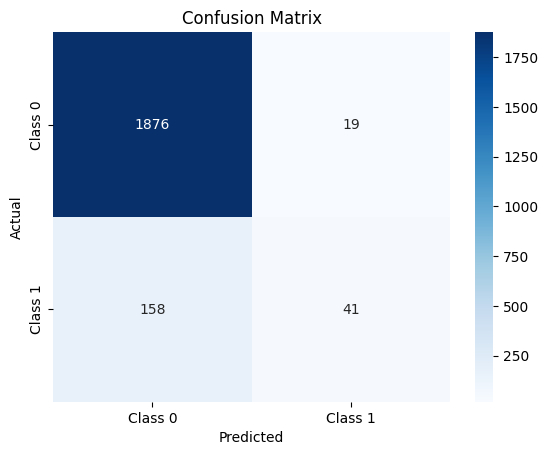

In [83]:
print("Classification Report:")
print(classification_report(targets.cpu().numpy(), preds.cpu().numpy()))

# Confusion matrix
cm = confusion_matrix(targets.cpu().numpy(), preds.cpu().numpy())
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()